In [57]:
import pandas as pd
from data_science_tools.datasets import AttrGeomSet
from data_science_tools.data_sources import BigQuery, Freyr, APISource
from data_science_tools.core import active_configuration
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import os
import asyncio
from data_science_tools.core.utils import progress_bar
from data_science_tools.tile_servers import ShowerV2
from data_science_tools.geometry import wkb_to_shapely, geojson_to_wkb, shapely_to_wkb, make_valid, wkb_to_geojson


# You need this line import to make the df.chipper accessor available
import data_science_tools.image_chipper
import json
import nest_asyncio

nest_asyncio.apply()

BOSTON_URL = active_configuration["data_sources"]["api_sources"]["boston"]["url_template"]
boston = APISource.from_mnemonic('boston')
fr = Freyr()

from warnings import warn

def get_rg_payload(row):
    survey = row["imagery_source"].split(':')[-1]
    geometry = row["geometry"]
    with open("/cnvrg/request_template_rg.json") as f:
        request_template = json.load(f)
        request_template["Supplied"]['Target.Geometry']['GeoJSON'] = wkb_to_geojson(geometry)
        request_template["Supplied"]["Tiles.TileServerData"]['Survey'] = survey
    return request_template


def request_rg(row):
    payload = get_rg_payload(row)
    response = boston.get_data(data=payload)
    if response.status_code != 200:
        warn(f"Request failed with status code {response.status_code}")
        return None
    return response.json()

def bulk_request_rg(rows):
    payloads = list(rows.apply(get_rg_payload, axis=1))

    #payloads = []
    #for row in rows:
    #    payload = request_homefinder(row)
    #    payloads.append(payload)
    
    all_responses = {}
    print('Found {} payloads'.format(len(payloads)))
    with progress_bar.progress_bar(len(rows), units="Geometry", title="Fetching from Boston") as pbar:
        for i, parameter, response in boston.get_data_bulk(n_threads=10, data=payloads):
            supplied = geojson_to_wkb(parameter['data']["Supplied"]['Target.Geometry']["GeoJSON"])
            if response.status_code != 200:
                warn(f"Request failed with status code {response.status_code}")
                all_responses[supplied] = None
            else:
                all_responses[supplied] = response.json()
            pbar.increase()
    
    return all_responses


# Run boston to obtain prod RG predictions

In [4]:
df = pd.read_parquet("/data/dino_fixed_rg_evaluation_slimtp/evaluate_mtmv_nearmap_rg/chips/dataset.parquet")
df = df[["geometry", "imagery_source"]].drop_duplicates()
responses = bulk_request_rg(df)

Found 11562 payloads
Fetching from Boston :

[****      14.8%             ]  1716 / 11562 Geometry in 53.6 s (0:05:05 to go)

/opt/conda/lib/python3.8/site-packages/data_science_tools/data_sources/api_sources.py:449: UserWarning: Requests for {'data': {'Requested': ['Inference.RoofGeometry'], 'Supplied': {'Target.Geometry': {'GeoJSON': {'type': 'Polygon', 'coordinates': (((-90.65632313489914, 35.8599112404501), (-90.65632581710815, 35.85990906665486), (-90.65632581710815, 35.85974820580763), (-90.65608978271484, 35.85974820580763), (-90.65608710050583, 35.8597460320124), (-90.65607368946075, 35.8597460320124), (-90.65607100725174, 35.85974385821717), (-90.65602272748947, 35.85974385821717), (-90.65602004528046, 35.85974168442194), (-90.65601736307144, 35.85974385821717), (-90.65600663423538, 35.85974385821717), (-90.65600395202637, 35.85974168442194), (-90.65599590539932, 35.85974168442194), (-90.65599322319031, 35.85974385821717), (-90.65594226121902, 35.85974385821717), (-90.65593957901001, 35.85974168442194), (-90.65592616796494, 35.85974168442194), (-90.65592348575592, 35.8597395106267), (-90.655789375305

[**********38.5%             ]  4452 / 11562 Geometry in 127.9 s (0:03:23 to go)

/opt/conda/lib/python3.8/site-packages/data_science_tools/data_sources/api_sources.py:449: UserWarning: Requests for {'data': {'Requested': ['Inference.RoofGeometry'], 'Supplied': {'Target.Geometry': {'GeoJSON': {'type': 'Polygon', 'coordinates': (((-90.71635097265244, 35.81282579999558), (-90.71640998125076, 35.81278012210127), (-90.71640998125076, 35.81277794696344), (-90.71642071008682, 35.81276924641215), (-90.71642071008682, 35.81276272099867), (-90.71632951498032, 35.81268876631264), (-90.71632951498032, 35.81268659117482), (-90.7163268327713, 35.81268659117482), (-90.71631610393524, 35.81267789062352), (-90.71631610393524, 35.81267571548569), (-90.71620613336563, 35.81258653483489), (-90.71620613336563, 35.81258435969706), (-90.71619540452957, 35.81257565914576), (-90.71618735790253, 35.81257565914576), (-90.71616053581238, 35.81259741052401), (-90.71614980697632, 35.81260176079966), (-90.71612030267715, 35.8126235121779), (-90.71611762046814, 35.8126235121779), (-90.71610957384

[**********78.7%*******      ]  9096 / 11562 Geometry in 247.5 s (0:01:07 to go)

/opt/conda/lib/python3.8/site-packages/data_science_tools/data_sources/api_sources.py:449: UserWarning: Requests for {'data': {'Requested': ['Inference.RoofGeometry'], 'Supplied': {'Target.Geometry': {'GeoJSON': {'type': 'Polygon', 'coordinates': (((-90.67138910293579, 35.80825797432597), (-90.67139714956284, 35.80825362380629), (-90.67139983177185, 35.80824492276693), (-90.67141056060791, 35.80822752068821), (-90.67142397165298, 35.80821229386932), (-90.67142397165298, 35.80820794334964), (-90.67143470048904, 35.80819054127092), (-90.67143738269806, 35.80817748971187), (-90.67145615816116, 35.8081470360741), (-90.67145615816116, 35.80814268555442), (-90.67147493362427, 35.80811223191666), (-90.67148298025131, 35.8081035308773), (-90.67148298025131, 35.80809918035762), (-90.67149370908737, 35.80808395353873), (-90.67149370908737, 35.80807960301905), (-90.67153930664062, 35.80800781944431), (-90.67153930664062, 35.80800346892463), (-90.67154467105865, 35.80799911840495), (-90.6715473532

[*********100.0%*************]  11562 / 11562 Geometry in 328.1 s (0:00:00 to go)


In [8]:
import tqdm
list_rg_df = []
for geometry, rg_result in tqdm.tqdm(responses.items(), total=len(responses)):
    if rg_result is None:
        # warn(f"Request failed with error code {parcel_attr_geom['result']['status']['error_code']}")
        itmp = pd.Series({"geometry": geometry, "rg_boston": None})
    else:
        itmp = pd.Series({"geometry": geometry, "rg_boston": rg_result['Inference.RoofGeometry']})
    list_rg_df.append(itmp)
rg_results_df = pd.concat(list_rg_df, axis=1, ignore_index=True).transpose()
rg_results_df.to_hdf('/cnvrg/rg_results_df.h5', key='data', mode='w')

100% 11562/11562 [00:02<00:00, 4709.81it/s]
/tmp/ipykernel_184/1904950329.py:11: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['geometry', 'rg_boston'], dtype='object')]

  rg_results_df.to_hdf('/cnvrg/rg_results_df.h5', key='data', mode='w')


In [37]:
rg_results_df = pd.read_hdf('/cnvrg/rg_results_df.h5')
print(len(rg_results_df))
rg_results_df = rg_results_df.dropna(subset="rg_boston")
print(len(rg_results_df))
rg_results_df["rg_boston_class"] = rg_results_df.rg_boston.apply(lambda d: pd.Series(d).index[pd.Series(d).argmax()])

11562
11559


In [40]:
original_df = pd.read_parquet("/data/dino_fixed_rg_evaluation_slimtp/evaluate_mtmv_nearmap_rg/chips/dataset.parquet")
df_with_rg_pred = pd.merge(original_df, rg_results_df, how="left", on="geometry", validate="many_to_one")
print(f"Initially had {len(original_df)} geometries")
df_with_rg_pred_no_nan = df_with_rg_pred.dropna(subset=["rg_boston_class"], axis=0)

print(f"Found {len(df_with_rg_pred_no_nan)} geometries with rg result")
df_with_rg_pred_no_nan.to_parquet('/cnvrg/df_with_rg_pred_no_nan.parquet')

Initially had 58211 geometries
Found 58197 geometries with rg result


In [41]:
df_with_rg_pred_no_nan.head()

,contact_id,geometry,geometry_id,geometry_labels,imagery_date,imagery_source,label_vote_id,label_vote_status,origin_mnemonic,filename,entry_hash,rg_boston,rg_boston_class
0,tandin.om@imerit.net,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00(\x00\x0...",cl_rg/20210204_test_set_nearmap_plus_vexcel: 4413,flat,2020-09-19 00:00:00+00:00,sv2:nearmap_vertical_jpg:49bd8944-fe9f-11ea-a6...,ckkxm8oh8000n3b60urhll0f8,in_review,cl_rg/20210415_model_test,02/0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f...,0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f3fe...,"{'flat': 0.9463387727737427, 'gable': 0.036230...",flat
1,shivlal.bediya@imerit.net,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00(\x00\x0...",cl_rg/20210204_test_set_nearmap_plus_vexcel: 4413,flat,2020-09-19 00:00:00+00:00,sv2:nearmap_vertical_jpg:49bd8944-fe9f-11ea-a6...,ckkxm88t300153b61u9fnc83j,in_review,cl_rg/20210415_model_test,02/0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f...,0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f3fe...,"{'flat': 0.9463387727737427, 'gable': 0.036230...",flat
2,ugyen.d@imerit.net,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00(\x00\x0...",cl_rg/20210204_test_set_nearmap_plus_vexcel: 4413,flat,2020-09-19 00:00:00+00:00,sv2:nearmap_vertical_jpg:49bd8944-fe9f-11ea-a6...,ckkxmbl22000i3b61ytu2adif,in_review,cl_rg/20210415_model_test,02/0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f...,0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f3fe...,"{'flat': 0.9463387727737427, 'gable': 0.036230...",flat
3,rinchen.z@imerit.net,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00(\x00\x0...",cl_rg/20210204_test_set_nearmap_plus_vexcel: 4413,flat,2020-09-19 00:00:00+00:00,sv2:nearmap_vertical_jpg:49bd8944-fe9f-11ea-a6...,ckkxme4fa00033b61otams6yf,in_review,cl_rg/20210415_model_test,02/0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f...,0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f3fe...,"{'flat': 0.9463387727737427, 'gable': 0.036230...",flat
4,noorhasan.ansari@imerit.net,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00(\x00\x0...",cl_rg/20210204_test_set_nearmap_plus_vexcel: 4413,flat,2020-09-19 00:00:00+00:00,sv2:nearmap_vertical_jpg:49bd8944-fe9f-11ea-a6...,ckkxm84ki000j3b61c6jze40y,in_review,cl_rg/20210415_model_test,02/0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f...,0290db6020c91ef1fc2d96c5dcec0456c9e55edc50f3fe...,"{'flat': 0.9463387727737427, 'gable': 0.036230...",flat


# Accumulate worker labels

In [42]:
import random

from collections import Counter

def majority_vote(vote_list):
    """Probably the 1,000th implementation of majority vote at cape.
    But this is a pretty fast one, with random tie-breaking.
    """
    counter = Counter(vote_list)
    return random.choice([x for x in counter if counter[x] == max(counter.values())])

df = df_with_rg_pred_no_nan
columns_to_keep = ["geometry", "imagery_source", "imagery_date", "rg_boston_class"]

groupby = "geometry_id"
if groupby is not None and groupby not in columns_to_keep:
    columns_to_keep.append(groupby)

# group votes, keep only required columns
if "geometry_labels" in df.columns:

    # Labeled dataset. Let's aggregate:

    cols_aggregations = {"geometry_labels": list}
    # If this dataset contains many votes, keep them
    if "label_vote_id" in df.columns:
        cols_aggregations["label_vote_id"] = list

    # Keep a few columns for bedrock datasets
    for col in ["cache_key", "dataset_path", "dataset_format", "filename", "chips_path"]:
        if col in df.columns:
            # Keep first
            cols_aggregations[col] = "first"  # type: ignore

    df_new = df.groupby(columns_to_keep)[list(cols_aggregations.keys())].agg(cols_aggregations).reset_index()
    df_new.geometry_labels = df_new.geometry_labels.apply(lambda x: majority_vote(x))
    df_new = df_new.drop(columns="label_vote_id")


In [43]:
df_new.head()

,geometry,imagery_source,imagery_date,rg_boston_class,geometry_id,geometry_labels,filename
0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:518c4f98-fe9f-11ea-b7...,2020-09-17 00:00:00+00:00,mixed_w_wind_credit,cl_rg/test_vexcel_plus_cl_rg_mixed_aois: 16,mixed_wo_wind_credit,68/689385cad5ced840bad14511af819170edda674f374...
1,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:031b1d2e-b967-11e7-a6...,2016-07-28 00:00:00+00:00,gable,cl_rg/20210204_test_set_nearmap_plus_vexcel: 4221,gable,8e/8e36ced2d77959dc1141d1e88cb22e6f9c351ae14ea...
2,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x02...,sv2:nearmap_vertical_jpg:3234ae72-b967-11e7-af...,2016-09-30 00:00:00+00:00,gable,cl_rg/20210204_test_set_nearmap_plus_vexcel: 1435,flat,9d/9de96dd11516c789e3c50edbb38b010ef360453f1fb...
3,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x01\x01...,sv2:nearmap_vertical_jpg:70d270ce-5232-11e8-8f...,2018-04-28 00:00:00+00:00,flat,cl_rg/20210204_test_set_nearmap_plus_vexcel: 3652,flat,d7/d75d309f0c9adf23185e7cfff3929d4e8553c84e8ea...
4,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x01\x01...,sv2:nearmap_vertical_jpg:757a2816-b966-11e7-ac...,2015-09-24 00:00:00+00:00,gable,cl_rg/20210204_test_set_nearmap_plus_vexcel: 3020,gable,15/150380e8a132dbfef3677029e5425c22cfa36d94243...


In [44]:
df_new.rg_boston_class.unique()

array(['mixed_w_wind_credit', 'gable', 'flat', 'unknown', 'hip',
       'mixed_wo_wind_credit'], dtype=object)

In [45]:
df_new.geometry_labels.unique()

array(['mixed_wo_wind_credit', 'gable', 'flat', 'unknown', 'hip',
       'mixed_w_wind_credit'], dtype=object)

In [48]:
df_with_rg_pred_no_nan_accumulated = df_new
df_with_rg_pred_no_nan_accumulated.to_parquet("/cnvrg/df_with_rg_pred_no_nan_accumulated.parquet")

In [50]:
from data_science_tools.taxonomies import Taxonomy
taxonomy = Taxonomy.from_spec("roof_geometry @ 2.0: ground_truth")
taxonomy.labels

['flat',
 'gable',
 'hip',
 'wind_credit',
 'no_wind_credit',
 'dutch_gable',
 'unknown',
 'other']

In [55]:
from typing import Dict, List, Sequence, Union
from sklearn.metrics import confusion_matrix

import numpy as np
def plot_cm(
    y_true: Union[Sequence, np.ndarray],
    y_pred: Union[Sequence, np.ndarray],
    name: str,
    labels: Union[Sequence, np.ndarray]
) -> None:
    """
    Plot confusion matrices.

    :param y_true: array-like of shape (n_samples,)
    :param y_pred: array-like of shape (n_samples,)
    :param name: name of the plot
    :param labels: array-like of shape (n_classes,), the class labels
    """

    fig = plt.figure(figsize=(12, 6), facecolor="w")
    for i, (sum_axis, cm_type, cm_name) in enumerate([(0, "column", "Precision"), (1, "row", "Recall")]):
        ax = fig.add_subplot(1, 2, i + 1)

        data = confusion_matrix(y_true, y_pred, labels=labels)

        norm_conf = data / (np.sum(data, axis=sum_axis, keepdims=True) + 1e-7)
        _ = ax.imshow(
            norm_conf,
            cmap=plt.get_cmap("coolwarm"),
            interpolation="nearest",
            vmin=0,
            vmax=1,
        )

        for x in range(len(labels)):
            for y in range(len(labels)):
                label = f"{data[y][x]}\n({norm_conf[y][x]:.2f})"

                ax.annotate(
                    label,
                    xy=(x, y),
                    horizontalalignment="center",
                    verticalalignment="center",
                    fontsize=8,
                )
        axis_labels = [c[:12] + (c[12:] and ".") for c in labels]
        ax.set_xticks(range(len(axis_labels)))
        ax.set_xticklabels(axis_labels, fontsize=8, rotation=45, horizontalalignment="right")
        ax.set_yticks(range(len(axis_labels)))
        ax.set_yticklabels(axis_labels, fontsize=8)

        if i == 0:
            ax.set_ylabel("GT")
        ax.set_xlabel("Prediction")

        title = f"{cm_name} ({cm_type} normalized)"
        ax.set_title(title)
        ax.autoscale()

    fig.tight_layout(rect=[0.0, 0.02, 1, 0.9])
    acc = np.sum([data[i, i] for i in range(len(data))]) / (1e-7 + np.sum(data))
    fig.suptitle(f"{name} ({len(y_true)} ex)\n Accuracy: {acc:.4f}", fontsize=12)
    plt.show()

def plot_confusion_matrices(split_df: pd.DataFrame, title='default') -> None:
    """
    Plot all confusion matrices.
    """
    y_true = np.array([pred for pred in split_df["geometry_labels"]])
    y_pred = np.array([pred for pred in split_df["rg_boston_class"]])

    plot_cm(y_true, y_pred, title, taxonomy.labels)

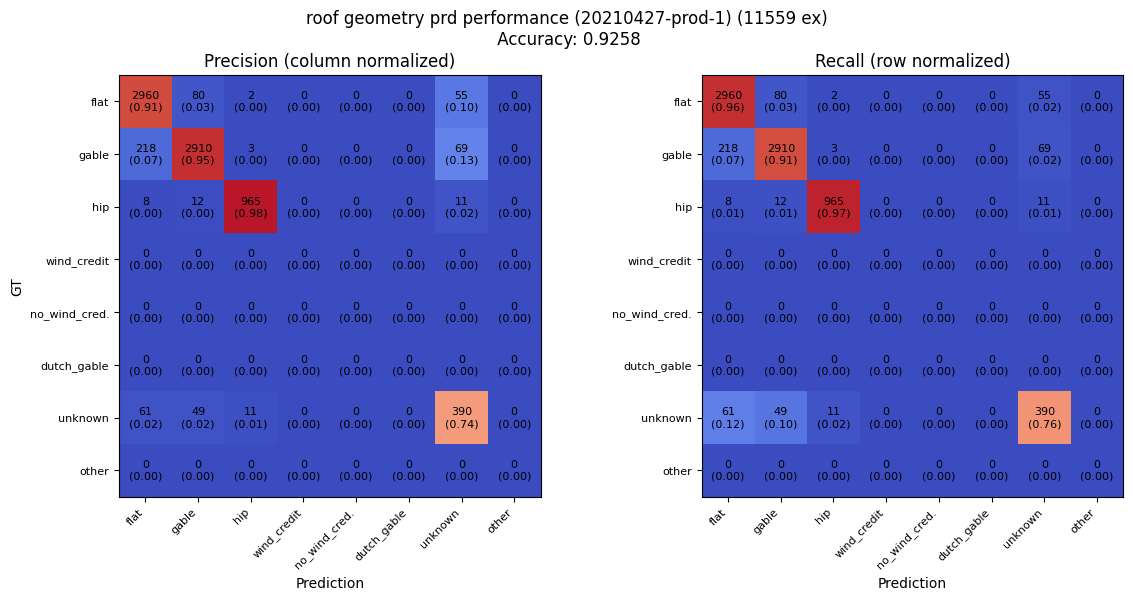

In [59]:
plot_confusion_matrices(df_with_rg_pred_no_nan_accumulated, "roof geometry prd performance (20210427-prod-1)")